In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


Using TensorFlow backend.


In [2]:
#Load PolyaDB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [3]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [14]:
#Load APADB and Leslie data

apadb_df = pd.read_csv("apa_leslie_derti_apadb_data_df.csv", sep='\t')

apadb_df['apadb_usage_pooled'] = apadb_df['apadb_count_pooled'] / apadb_df['apadb_total_count_pooled']
apadb_df['leslie_usage_pooled'] = apadb_df['leslie_count_pooled'] / apadb_df['leslie_total_count_pooled']

apadb_df['leslie_usage_hek293'] = apadb_df['leslie_count_hek293'] / apadb_df['leslie_total_count_hek293']
apadb_df['leslie_usage_testis'] = apadb_df['leslie_count_testis'] / apadb_df['leslie_total_count_testis']
apadb_df['leslie_usage_ovary'] = apadb_df['leslie_count_ovary'] / apadb_df['leslie_total_count_ovary']
apadb_df['leslie_usage_blcl'] = apadb_df['leslie_count_blcl'] / apadb_df['leslie_total_count_blcl']
apadb_df['leslie_usage_brain'] = apadb_df['leslie_count_brain'] / apadb_df['leslie_total_count_brain']


In [15]:

apadb_df['join_id'] = apadb_df['chrom'] + "_" + apadb_df['gene'] + "_" + apadb_df['pas_pos'].astype(str)
polyadb_df['join_id'] = polyadb_df['chrom'] + "_" + polyadb_df['gene'] + "_" + polyadb_df['pas_pos'].astype(str)

join_df = polyadb_df.join(apadb_df[[
    'join_id',
    'apadb_usage_pooled', 'apadb_total_count_pooled',
    'leslie_usage_pooled', 'leslie_total_count_pooled',
    
    'leslie_usage_hek293', 'leslie_total_count_hek293',
    'leslie_usage_testis', 'leslie_total_count_testis',
    'leslie_usage_ovary', 'leslie_total_count_ovary',
    'leslie_usage_blcl', 'leslie_total_count_blcl',
    'leslie_usage_brain', 'leslie_total_count_brain',
]].set_index("join_id"), on="join_id", how='inner').drop_duplicates(subset=['join_id'], keep='first').copy().reset_index(drop=True)

join_df = join_df[[
    'gene',
    'gene_id',
    'pas',
    'sitenum',
    'num_sites',
    'site_type',
    'ratio',
    'apadb_usage_pooled', 'apadb_total_count_pooled',
    'leslie_usage_pooled', 'leslie_total_count_pooled',
    
    'leslie_usage_hek293', 'leslie_total_count_hek293',
    'leslie_usage_testis', 'leslie_total_count_testis',
    'leslie_usage_ovary', 'leslie_total_count_ovary',
    'leslie_usage_blcl', 'leslie_total_count_blcl',
    'leslie_usage_brain', 'leslie_total_count_brain',
]]


SpearmanrResult(correlation=0.7470209737956849, pvalue=0.0)
n = 35026


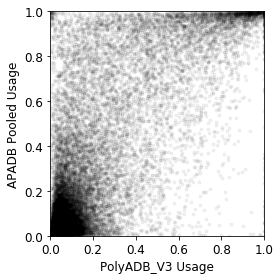

SpearmanrResult(correlation=0.7402609694584463, pvalue=0.0)
n = 34896


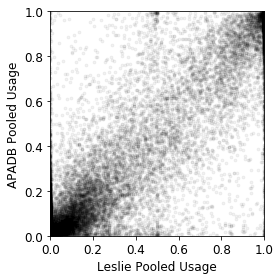

SpearmanrResult(correlation=0.9682231508702657, pvalue=0.0)
n = 29317


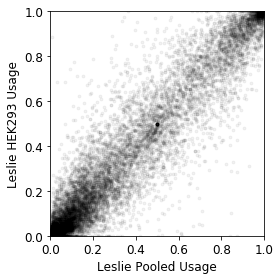

SpearmanrResult(correlation=0.9598449889712467, pvalue=0.0)
n = 28435


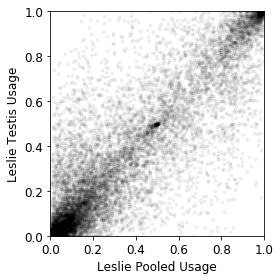

SpearmanrResult(correlation=0.9573669299610844, pvalue=0.0)
n = 28903


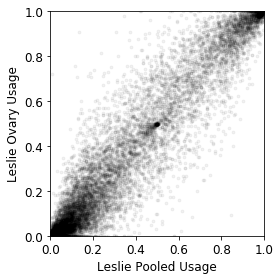

SpearmanrResult(correlation=0.9725883287834978, pvalue=0.0)
n = 28555


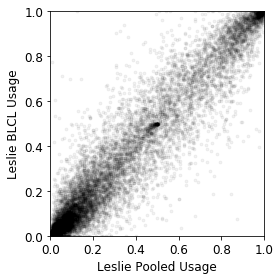

SpearmanrResult(correlation=0.9656849881866543, pvalue=0.0)
n = 31949


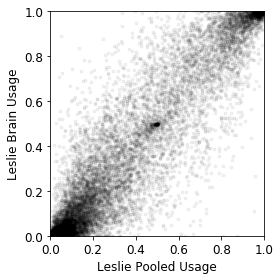

In [17]:
from scipy.stats import spearmanr

#PolyADB vs. APADB Pooled
filtered_df = join_df.query("apadb_total_count_pooled >= 20")

print(spearmanr(filtered_df['ratio'], filtered_df['apadb_usage_pooled']))
print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['ratio'], filtered_df['apadb_usage_pooled'], alpha=0.05, s=8, color='black')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("PolyADB_V3 Usage", fontsize=12)
plt.ylabel("APADB Pooled Usage", fontsize=12)

plt.tight_layout()

plt.show()

#Leslie Pooled vs. APADB Pooled
filtered_df = join_df.query("leslie_total_count_pooled >= 20 and apadb_total_count_pooled >= 20")

print(spearmanr(filtered_df['leslie_usage_pooled'], filtered_df['apadb_usage_pooled']))
print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['leslie_usage_pooled'], filtered_df['apadb_usage_pooled'], alpha=0.05, s=8, color='black')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Leslie Pooled Usage", fontsize=12)
plt.ylabel("APADB Pooled Usage", fontsize=12)

plt.tight_layout()

plt.show()

#Leslie Pooled vs. HEK293
filtered_df = join_df.query("leslie_total_count_pooled >= 20 and leslie_total_count_hek293 >= 20")

print(spearmanr(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_hek293']))
print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_hek293'], alpha=0.05, s=8, color='black')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Leslie Pooled Usage", fontsize=12)
plt.ylabel("Leslie HEK293 Usage", fontsize=12)

plt.tight_layout()

plt.show()

#Leslie Pooled vs. Testis
filtered_df = join_df.query("leslie_total_count_pooled >= 20 and leslie_total_count_testis >= 20")

print(spearmanr(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_testis']))
print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_testis'], alpha=0.05, s=8, color='black')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Leslie Pooled Usage", fontsize=12)
plt.ylabel("Leslie Testis Usage", fontsize=12)

plt.tight_layout()

plt.show()

#Leslie Pooled vs. Ovary
filtered_df = join_df.query("leslie_total_count_pooled >= 20 and leslie_total_count_ovary >= 20")

print(spearmanr(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_ovary']))
print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_ovary'], alpha=0.05, s=8, color='black')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Leslie Pooled Usage", fontsize=12)
plt.ylabel("Leslie Ovary Usage", fontsize=12)

plt.tight_layout()

plt.show()

#Leslie Pooled vs. HEK293
filtered_df = join_df.query("leslie_total_count_pooled >= 20 and leslie_total_count_blcl >= 20")

print(spearmanr(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_blcl']))
print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_blcl'], alpha=0.05, s=8, color='black')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Leslie Pooled Usage", fontsize=12)
plt.ylabel("Leslie BLCL Usage", fontsize=12)

plt.tight_layout()

plt.show()

#Leslie Pooled vs. Brain
filtered_df = join_df.query("leslie_total_count_pooled >= 20 and leslie_total_count_brain >= 20")

print(spearmanr(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_brain']))
print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['leslie_usage_pooled'], filtered_df['leslie_usage_brain'], alpha=0.05, s=8, color='black')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Leslie Pooled Usage", fontsize=12)
plt.ylabel("Leslie Brain Usage", fontsize=12)

plt.tight_layout()

plt.show()
